In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.ensemble import \
    RandomForestRegressor  # Use RandomForestClassifier for classification
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, TensorDataset

In [33]:
df_oni = pd.read_csv("../../datasets/csv/ONI_data.csv")
df_oni = df_oni.rename(columns={"Year": "year"})
df_oni = df_oni.drop(["DJF", "NDJ"], axis=1)
df_oni.head()

,year,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND
0,1950,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6
1,1951,-0.5,-0.2,0.2,0.4,0.6,0.7,0.9,1.0,1.2,1.0
2,1952,0.4,0.3,0.3,0.2,0.0,-0.1,0.0,0.2,0.1,0.0
3,1953,0.6,0.6,0.7,0.8,0.8,0.7,0.7,0.8,0.8,0.8
4,1954,0.5,0.0,-0.4,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7


In [34]:
df_oni = df_oni.melt(id_vars=["year"], var_name="season", value_name="ONI")

In [35]:
df_oni.head()

,year,season,ONI
0,1950,JFM,-1.3
1,1951,JFM,-0.5
2,1952,JFM,0.4
3,1953,JFM,0.6
4,1954,JFM,0.5


In [36]:
season_to_month = {
    "JFM": "February",
    "FMA": "March",
    "MAM": "April",
    "AMJ": "May",
    "MJJ": "June",
    "JJA": "July",
    "JAS": "August",
    "ASO": "September",
    "SON": "October",
    "OND": "November"
}

season_to_month_num = {
    "JFM": 2,  # February
    "FMA": 3,  # March
    "MAM": 4,  # April
    "AMJ": 5,  # May
    "MJJ": 6,  # June
    "JJA": 7,  # July
    "JAS": 8,  # August
    "ASO": 9,  # September
    "SON": 10, # October
    "OND": 11  # November
}

In [37]:
# df_oni["month"] = df_oni["season"].map(season_to_month)
df_oni["month"] = df_oni["season"].map(season_to_month_num)
df_oni.head()

,year,season,ONI,month
0,1950,JFM,-1.3,2
1,1951,JFM,-0.5,2
2,1952,JFM,0.4,2
3,1953,JFM,0.6,2
4,1954,JFM,0.5,2


In [38]:
df_enso = pd.read_csv("../../datasets/csv/enso_data.csv")
df_enso = df_enso.rename(columns={"YR": "year", "MON": "month"})
df_enso.head()

,year,month,TOTAL,ClimAdjust,ANOM
0,1950,1,24.56,26.18,-1.62
1,1950,2,25.07,26.39,-1.32
2,1950,3,25.88,26.95,-1.07
3,1950,4,26.29,27.39,-1.11
4,1950,5,26.19,27.56,-1.37


In [39]:
df_features = pd.merge(
    df_enso, df_oni, on=["year", "month"], how="inner"
).dropna()
df_features.head()

,year,month,TOTAL,ClimAdjust,ANOM,season,ONI
0,1950,2,25.07,26.39,-1.32,JFM,-1.3
1,1950,3,25.88,26.95,-1.07,FMA,-1.2
2,1950,4,26.29,27.39,-1.11,MAM,-1.2
3,1950,5,26.19,27.56,-1.37,AMJ,-1.1
4,1950,6,26.47,27.21,-0.74,MJJ,-0.9


In [40]:
print(len(df_features))
print(len(df_oni))
print(len(df_enso))

750
750
901


In [41]:
df_label = pd.read_csv('../../datasets/csv/doy_cherry_peak_bloom_Japan_Tsu.csv')

In [42]:
df = pd.merge(df_label, df_features, on='year', how='inner').dropna()
df.sample(10)

,year,doy_cherry_peak_bloom,month,TOTAL,ClimAdjust,ANOM,season,ONI
187,1971,97,9,25.71,26.42,-0.71,ASO,-0.8
15,1954,94,7,26.10,26.72,-0.62,JJA,-0.6
501,2003,92,3,27.66,27.21,0.45,FMA,0.4
22,1955,95,4,26.61,27.39,-0.78,MAM,-0.8
466,1999,93,8,25.64,26.83,-1.19,JAS,-1.1
18,1954,94,10,25.22,26.01,-0.78,SON,-0.8
348,1987,96,10,27.95,26.54,1.42,SON,1.5
279,1980,98,11,26.60,26.46,0.14,OND,0.1
322,1985,96,4,26.65,27.59,-0.93,MAM,-0.8
69,1959,91,11,26.04,26.10,-0.06,OND,0.0


In [43]:
# Assign a numerical value to each season category
df['season_encoded'] = df['season'].map(season_to_month_num)

# Create the cyclical features using sine and cosine
# We divide by the total number of categories to map the values to [0, 2π)
num_seasons = len(season_to_month_num) 
df['season_sin'] = np.sin(2 * np.pi * df['season_encoded'] / num_seasons)
df['season_cos'] = np.cos(2 * np.pi * df['season_encoded'] / num_seasons)

In [44]:
# Sort data by year to ensure chronological order
df = df.sort_values("year")

# Define features (X) and target (y)
# Drop the intermediate encoding and the original category
X = df.drop(columns=["season", "season_encoded", "year", "doy_cherry_peak_bloom"])
y = df["doy_cherry_peak_bloom"]  # Target variable

# Define the cut-off point (e.g., last 20% of years for testing)
split_idx = int(len(df) * 0.8)

# Create the train/test split
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Print the shapes of the splits
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (552, 7), Test set: (138, 7)


In [45]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)
doy_pred_training = rf.predict(X_train)

# Make predictions on the test set
doy_pred = rf.predict(X_test)

In [46]:
# Evaluate the model
mse = mean_squared_error(y_test, doy_pred)
r2 = r2_score(y_test, doy_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 34.20301971665189
R2 Score: -1.8923725909587854


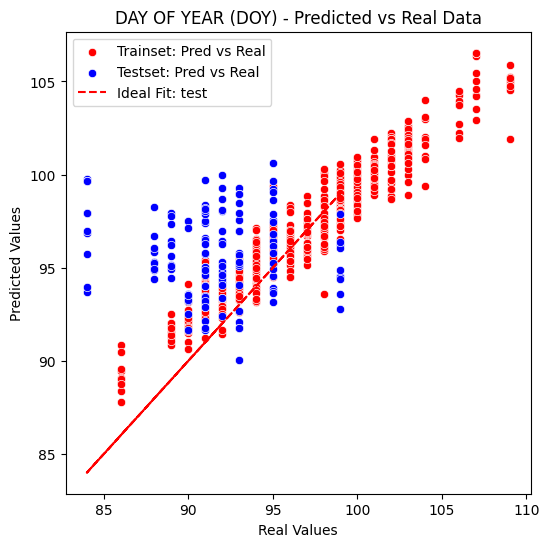

In [47]:
# Example data
real_values = y_test
predicted_values = doy_pred

# Create scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=doy_pred_training, label="Trainset: Pred vs Real", color="red")

sns.scatterplot(x=real_values, y=predicted_values, label="Testset: Pred vs Real", color="blue")

# Plot y=x line for reference
plt.plot(real_values, real_values, color="red", linestyle="--", label="Ideal Fit: test")

# Labels and title
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("DAY OF YEAR (DOY) - Predicted vs Real Data")
plt.legend()

# Show plot
plt.show()

      Feature  Importance
2  ClimAdjust    0.266899
1       TOTAL    0.253382
3        ANOM    0.212103
4         ONI    0.141184
0       month    0.053573
6  season_cos    0.042363
5  season_sin    0.030495


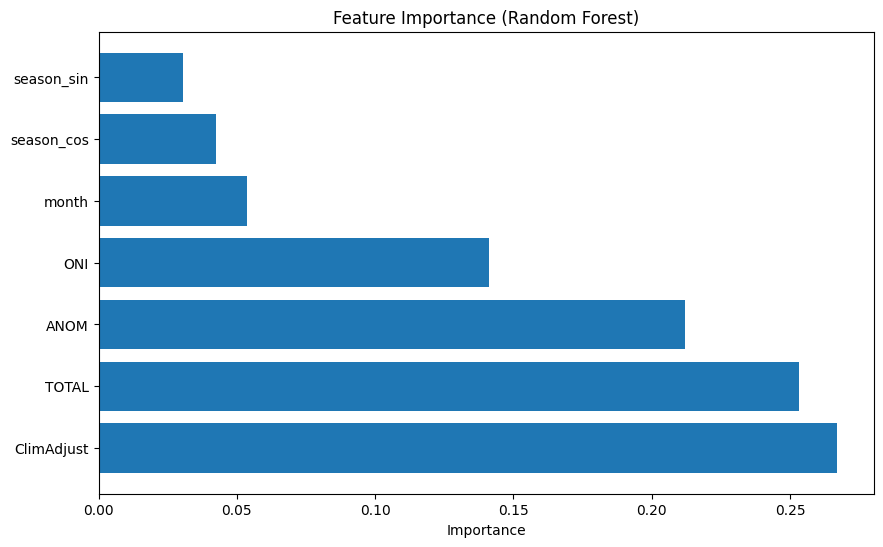

In [48]:
# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

## LSTM

In [ ]:
# Reshape data into sequences
def reshape_data(X, seq_length=10, input_dim=7):
    """
    Reshape data into sequences for LSTM.
    Args:
        X: Input data of shape (num_samples, num_features)
        seq_length: Number of time steps in each sequence
        input_dim: Number of features per time step
    Returns:
        Reshaped data of shape (num_samples, seq_length, input_dim)
    """
    X_array = X.values
    num_samples = X_array.shape[0]

    # Ensure the data can be divided into sequences
    assert (
        X_array.shape[1] == input_dim
    ), f"Expected {input_dim} features, got {X_array.shape[1]}"

    # Create sequences by sliding a window over the data
    sequences = []
    for i in range(num_samples - seq_length + 1):
        sequences.append(X_array[i : i + seq_length, :])

    return np.array(sequences)

In [ ]:
# Reshape training and test data
seq_length = 10  # Number of time steps in each sequence
input_dim = 7  # Number of features per time step

X_train_reshaped = reshape_data(X_train, seq_length, input_dim)
X_test_reshaped = reshape_data(X_test, seq_length, input_dim)

# Adjust target variables to match the sequences
y_train_reshaped = y_train[seq_length - 1 :].values
y_test_reshaped = y_test[seq_length - 1 :].values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_reshaped).cuda()
y_train_tensor = torch.FloatTensor(y_train_reshaped).cuda()
X_test_tensor = torch.FloatTensor(X_test_reshaped).cuda()
y_test_tensor = torch.FloatTensor(y_test_reshaped).cuda()

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

trn_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tst_dl = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True,
        )

        # Final output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Decode the last hidden state
        out = self.fc(hn[-1])
        return out

In [ ]:
# Initialize model with your parameters
input_dim = 7
hidden_dim = 256
layer_dim = 3
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).cuda()
criterion = nn.MSELoss()
opt = torch.optim.RMSprop(model.parameters(), lr=0.0005)

# Training loop with early stopping
n_epochs = 50000
best_mse = float("inf")
patience, trials = 200, 0

for epoch in range(n_epochs):
    model.train()
    for inputs, targets in trn_dl:
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        opt.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        test_loss = criterion(test_preds.squeeze(), y_test_tensor)

    if test_loss < best_mse:
        best_mse = test_loss
        trials = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch:5} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}"
        )

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

Epoch     0 | Train Loss: 6650.7100 | Test Loss: 5679.8364
Epoch   100 | Train Loss: 19.1778 | Test Loss: 47.6897
Epoch   200 | Train Loss: 28.4242 | Test Loss: 48.9738
Early stopping at epoch 243


<All keys matched successfully>

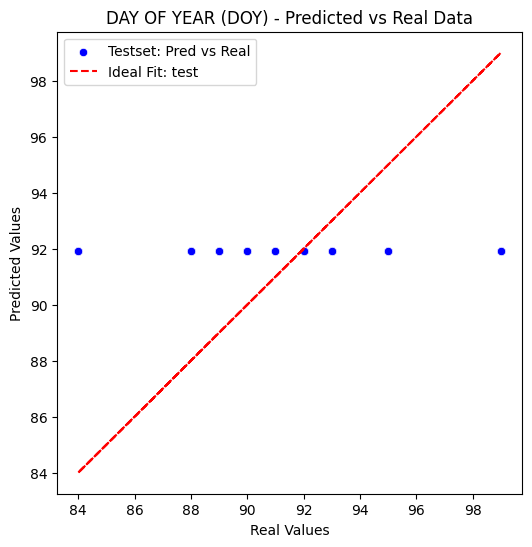

In [ ]:
# Assuming you have already trained your model and made predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).cpu().numpy()

real_values = y_test_tensor.cpu().numpy().flatten()  # Ensure 1D
predicted_values = test_preds.flatten()  # Ensure 1D

# Create scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=real_values, y=predicted_values, label="Testset: Pred vs Real", color="blue"
)

# Plot y=x line for reference
plt.plot(real_values, real_values, color="red", linestyle="--", label="Ideal Fit: test")

# Labels and title
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("DAY OF YEAR (DOY) - Predicted vs Real Data")
plt.legend()

# Show plot
plt.show()